In [1]:
# ! pip install  matplotlib
# ! pip install Pillow
#! pip install --upgrade opencv-python
# ! pip install scikit-learn
#!pip install numpy

In [2]:
# Initialisation of libraries/directories
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as Img
import os
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *

Using TensorFlow backend.


In [3]:
%matplotlib inline

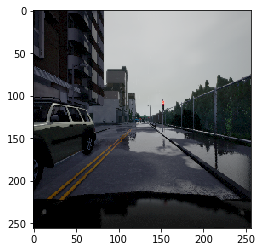

In [4]:
img=cv2.imread('/jet/prs/workspace/Data/Raw_Data/02_00_000.png')[:,:,::-1]
img=cv2.resize(img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
plt.imshow(img)

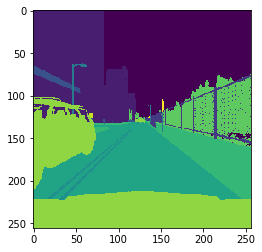

In [5]:
img=cv2.imread('/jet/prs/workspace/Data/Mask_data/02_00_000.png') 
img=cv2.resize(img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)[:,:,2]
plt.imshow(img)

In [6]:
labels = list(np.unique(img))
labels

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]

In [7]:
from keras.models import *
from keras.layers import *


import os

In [8]:
import numpy as np
import cv2
import glob
import itertools
def generator(image_path, mask_path, batch_size, input_height, input_width, labels):
    
    assert image_path[-1] == '/'
    assert mask_path[-1] == '/'
    
    images = glob.glob( image_path + "*.png"  ) 
    images.sort()
    segmentations  = glob.glob( mask_path + "*.png"  )
    segmentations.sort()
    
    #no of images in both folders is same
    assert len( images ) == len(segmentations)
    
    #Files are in correspondance
    for im , seg in zip(images,segmentations):
        assert(  im.split('/')[-1].split(".")[0] ==  seg.split('/')[-1].split(".")[0] )
        
    zipped = itertools.cycle( zip(images,segmentations) )
    
    while True:
        X = []
        Y = []
        for _ in range( batch_size) :
            im , seg = next(zipped)
            
            img = cv2.imread(im)[:,:,::-1]
            img = img.astype(np.float32)
            img = img/255.0
            img = cv2.resize(img, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST )
            img = np.rollaxis(img, 2, 0)
            
            X.append(img)
            
            img1 = cv2.imread(seg)
            img1 = cv2.resize(img1, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)[:,:,2]
            
            seg_labels = np.zeros((  input_height , input_width  , len(labels)))
            
            
            
            for c,l in enumerate(labels):
                seg_labels[: , : , c ] = ((img1 == l))*1
            
            seg_labels = seg_labels.astype(np.float32)
            
            seg_labels = np.reshape(seg_labels, ( input_height*input_width , len(labels) ))
               
            Y.append(seg_labels)

        yield np.array(X) , np.array(Y)
    

In [9]:
a = generator('/jet/prs/workspace/Data/Raw_Data/' , '/jet/prs/workspace/Data/Mask_data/', 5, 224,224,labels)

In [10]:
VGG_Weights_path = "/jet/prs/workspace/vgg16_weights_th_dim_ordering_th_kernels.h5"
IMAGE_ORDERING = 'channels_first'

In [11]:
def crop( o1 , o2 , i  ):
	o_shape2 = Model( i  , o2 ).output_shape
	outputHeight2 = o_shape2[2]
	outputWidth2 = o_shape2[3]

	o_shape1 = Model( i  , o1 ).output_shape
	outputHeight1 = o_shape1[2]
	outputWidth1 = o_shape1[3]

	cx = abs( outputWidth1 - outputWidth2 )
	cy = abs( outputHeight2 - outputHeight1 )

	if outputWidth1 > outputWidth2:
		o1 = Cropping2D( cropping=((0,0) ,  (  0 , cx )), data_format=IMAGE_ORDERING  )(o1)
	else:
		o2 = Cropping2D( cropping=((0,0) ,  (  0 , cx )), data_format=IMAGE_ORDERING  )(o2)
	
	if outputHeight1 > outputHeight2 :
		o1 = Cropping2D( cropping=((0,cy) ,  (  0 , 0 )), data_format=IMAGE_ORDERING  )(o1)
	else:
		o2 = Cropping2D( cropping=((0, cy ) ,  (  0 , 0 )), data_format=IMAGE_ORDERING  )(o2)

	return o1 , o2 

In [12]:
# # !pip install wget
# import wget
# url = "https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels.h5"
# filename = wget.download(url)

In [13]:
def FCN8( nClasses ,  input_height=416, input_width=608 , vgg_level=3):

	# assert input_height%32 == 0
	# assert input_width%32 == 0

	# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels.h5
	img_input = Input(shape=(  3, input_height,input_width))

	x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
	x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
	f1 = x
	# Block 2
	x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
	x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
	f2 = x

	# Block 3
	x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
	x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
	x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
	f3 = x

	# Block 4
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)
	f4 = x

	# Block 5
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)
	f5 = x

	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	x = Dense( 1000 , activation='softmax', name='predictions')(x)

	vgg  = Model(  img_input , x  )
	vgg.load_weights(VGG_Weights_path)

	o = f5

	o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
	o = Dropout(0.5)(o)
	o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
	o = Dropout(0.5)(o)

	o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
	o = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING )(o)

	o2 = f4
	o2 = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o2)
	
	o , o2 = crop( o , o2 , img_input )
	
	o = Add()([ o , o2 ])

	o = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING )(o)
	o2 = f3 
	o2 = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o2)
	o2 , o = crop( o2 , o , img_input )
	o  = Add()([ o2 , o ])


	o = Conv2DTranspose( nClasses , kernel_size=(16,16) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
	o = Cropping2D(cropping = ((0,8),(0,8))  , data_format=IMAGE_ORDERING)(o)
	o_shape = Model(img_input , o ).output_shape
	
	outputHeight = o_shape[2]
	outputWidth = o_shape[3]

	o = (Reshape((  -1  , outputHeight*outputWidth   )))(o)

	o = (Permute((2, 1)))(o)
	o = (Activation('softmax'))(o)
	model = Model( img_input , o )
	model.outputWidth = outputWidth
	model.outputHeight = outputHeight

	return model

In [14]:
model=FCN8(12,224,224)

ResourceExhaustedError: OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: fc1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=581108, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fc1/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'fc1/random_uniform/RandomUniform', defined at:
  File "/jet/var/python/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/jet/var/python/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/jet/var/python/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/jet/var/python/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/jet/var/python/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/jet/var/python/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/jet/var/python/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/jet/var/python/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/jet/var/python/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/jet/var/python/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/jet/var/python/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/jet/var/python/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/jet/var/python/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/jet/var/python/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/jet/var/python/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/jet/var/python/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/jet/var/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/jet/var/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/jet/var/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-d19c8ba2d780>", line 1, in <module>
    model=FCN8(12,224,224)
  File "<ipython-input-13-e7d93dfa97a9>", line 41, in FCN8
    x = Dense(4096, activation='relu', name='fc1')(x)
  File "/jet/var/python/lib/python3.6/site-packages/keras/engine/base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "/jet/var/python/lib/python3.6/site-packages/keras/layers/core.py", line 861, in build
    constraint=self.kernel_constraint)
  File "/jet/var/python/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/jet/var/python/lib/python3.6/site-packages/keras/engine/base_layer.py", line 249, in add_weight
    weight = K.variable(initializer(shape),
  File "/jet/var/python/lib/python3.6/site-packages/keras/initializers.py", line 218, in __call__
    dtype=dtype, seed=self.seed)
  File "/jet/var/python/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 4049, in random_uniform
    dtype=dtype, seed=seed)
  File "/jet/var/python/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 242, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "/jet/var/python/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 732, in random_uniform
    name=name)
  File "/jet/var/python/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/jet/var/python/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/jet/var/python/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/jet/var/python/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: fc1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=581108, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fc1/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
model.output_shape

In [ ]:
model.summary()

In [ ]:
for layer in model.layers[0:19]:
    layer.trainable = False

In [ ]:
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_crossentropy
model.compile(optimizer=Adam(lr=.0001), loss= 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit_generator( a , 1000  , epochs=10 )
model.save( "model_vgg.h5")

Epoch 1/5
 15/100 [===>..........................] - ETA: 1:04:16 - loss: 1.2717 - acc: 0.5914